# DataCleaning (Class Data)

In [22]:
#import required modules:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


## <span style="color:red">Description of the Class Data</span>
#### The class has 2 imputs: A Pandas DataFrame and a name:

--> To create an instance ot the Class Data, use following lines:
```json
dataframe = pd.read_csv("PATH TO DATA")
name="DESIRED NAME"
LakeAegeri=Data(dataframe,name)
```

#### The Class has various methods:
##### 1. The INSTANCE_CLASS_DATA.calc_rolling_statistics(column,window,plot="n",save_plot="n")
This method will calculate the rolling statistics and outputs a plot.

If you don't want the plot plotted in the notebook, use show_plot="n".

If you want to save the plot in the /data/output/.. folder:
- save_plot="y" -> It asks you to input a name without a space.
- save_plot="CUSTOM_NAME" -> It creates a plot with the name CUSTOM_NAME in the specified folder
- save_plot="n": It will not save the created figure
If you want to define the rolling window, use window=INTEGER


##### 2. The INSTANCE_CLASS_DATA.check_stationarity(column)
This method will check the stationarity using the Augmented Dickey-Fuller Test (ADF). As an input use the column you want the stationarity checked on.


##### 3. INSTANCE_CLASS_DATA.detect_outlier(column,knn_imputation="y",PERIOD=24,display_plots="y"):
This method will clean the data with help of the seasonal decomposition of the specified column (column=COLUMN_NAME). The method returns a (TimeSeries) cleaned DataFrame with the selected column. The physical impossible outliers are not cleaned in this method.

If you want the more "fancy" K-nearest Neighbours Algorithm Imputation, use knn_imputation="y". It looks at the 4 neighbours of the outlier and calculates an optimal value to replace the outlier. Otherwise, use knn_imputation="n" to use the simple imputer: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3. In the last step.

PERIOD: If you want to change the period of the data, change the PERIOD parameter.

Display plots in the notebook: If you want to display the plots, use display_plots="y", else display_plots="n"

##### 4. INSTANCE_CLASS_DATA.outlier_physical()...

In [23]:
#TODO: MARKDOWN TEXT ADJUST KNN TO SPLINE-ALGORITHM
#TODO: MARKDOWN TEXT ADD DAMIANS METHODS
#TODO: Explain the output outputs an instance of the class Data


class Data:
    def __init__(self, dataframe, name, set_index_datetime_int="y"):
        self.name = name
        self.dataframe = dataframe
        self.columns = self.dataframe.columns
        #convert the strings and add the datetime column to index
        self.dataframe["datetime"] = pd.to_datetime(self.dataframe["datetime"])

        index_name = self.dataframe.index.name  #this is used further below in the else: statement
        self.dataframe = self.dataframe.reset_index()

        if set_index_datetime_int == "y":
            self.dataframe.index = self.dataframe["x"]
            self.dataframe = self.dataframe.drop(columns=["x", "index"])
        else:
            self.dataframe.index = self.dataframe[index_name]
            self.dataframe = self.dataframe.drop(columns=[index_name])

    def __repr__(self):
        return f"DataFrame {name} with columns: {str(list(self.columns))}"

    def calc_rolling_statistics(self, column, window, show_plot="no", save_plot="no"):
        mean_rm = self.dataframe[column].rolling(window=window).mean()
        std_rm = self.dataframe[column].rolling(window=window).std()

        plt.style.context
        plt.rc('figure', figsize=(10, 6))
        fig, ax = plt.subplots(1, sharex=False, sharey=False)
        ax.plot(self.dataframe["datetime"], self.dataframe[column], color='red', label='Actual', alpha=0.7)
        ax.plot(self.dataframe["datetime"], mean_rm, color='green', label=f'Rolling Mean (window: {window})', alpha=0.7)
        ax.plot(self.dataframe["datetime"], std_rm, color='black', label=f'Rolling Std (window: {window})', alpha=0.7)
        plt.legend(loc='best')
        plt.title(f'Rolling Mean & Standard Deviation of {column}')

        if save_plot == "y":
            plt.savefig(f"./data/output_png/{input('How should the figure be named? (no Spaces!)')}.png")
        elif save_plot != "no":
            plt.savefig(f"./data/output_png/{save_plot}.png")

        if show_plot == "n":
            plt.close()
        plt.show(block=False)

    def check_stationarity(self, column):
        print(f"Visual check is advised with {self.name}.calc_rolling_statsitics(...,plot='Y')")
        print(
            "->  A stationary Time Series is one which characteristics like mean and variance does not change over time.")
        print(
            "Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:")
        print("--------------------")
        print('Dickey-Fuller Test: ')
        X = self.dataframe[column].dropna().values
        dftest = adfuller(X, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'No. of Obs'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value

        if list(dfoutput.items())[1][1] > 0.05:
            print(
                f"with a p-value of {round(list(dfoutput.items())[1][1], 3)}, we fail to reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return False
        else:
            print(
                f"with a p-value of {round(list(dfoutput.items())[1][1], 3)}, we reject the null hypothesis, that the data is stationary.")
            print(dfoutput)

    def detect_outlier(self, column, splines_imputation="y", PERIOD=24, display_plots="y"):
        ### 1. Prepare Dataset for the seasonal seasonal_decompose function:
        pd.set_option('display.max_rows', None)
        dataframe_noNAN = self.dataframe.dropna()
        dataframe_noNAN = dataframe_noNAN.reset_index()
        dataframe_noNAN = dataframe_noNAN.set_index("datetime")

        #set plot size:
        plt.rc('figure', figsize=(10, 6))
        plt.rc('font', size=10)

        ### 2. Seasonal decompose
        result = seasonal_decompose(dataframe_noNAN[[column]], period=PERIOD)

        #plot the seseasonal_decompose:
        fig, ax = plt.subplots(4, sharex=False, sharey=False)
        fig.subplots_adjust(bottom=7, top=9)

        ax[0].plot(result.observed, color="blue")
        ax[0].set_title("Result observed")

        ax[1].plot(result.seasonal, color="red")
        ax[1].set_title(f"seasonality of Period {PERIOD}")

        ax[2].plot(result.trend, color="green")
        ax[2].set_title("Trend")

        ax[3].plot(result.resid, color="orange")
        ax[3].set_title("Residuals")

        if display_plots != "y":
            plt.close()
        plt.show()

        ## 2.1 residuals (imputation yes or no)
        seasonal_df = result.seasonal.to_frame()
        trend_df = result.observed.to_frame()
        residuals_df = result.resid.to_frame()

        # 2.1.1 Normalize residuals:
        mean = residuals_df.mean()
        std = residuals_df.std()
        residuals_df_norm = residuals_df.copy()
        residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0]) / std[0]

        # 2.1.2 If the normalized residuals exceed +/- 3, then this is considered an outlier:
        residuals_df_norm['is_outlier'] = np.where((residuals_df_norm['resid'] > 3) | (residuals_df_norm['resid'] < -3),
                                                   True, False)
        print(f"------- number of outliers of {column} (normalized residuals exceed 3 or -3): ---------\n",
              residuals_df_norm["is_outlier"].value_counts())

        #plot exceeded residuals:
        fig, ax = plt.subplots()
        ax.scatter(residuals_df_norm.reset_index()["datetime"], residuals_df_norm.reset_index()["resid"],
                   c=residuals_df_norm["is_outlier"], cmap=cm.Set2, s=1)
        ax.axhline(3, color="red")
        ax.axhline(-3, color="red")
        if display_plots != "y":
            plt.close()
        plt.show()

        # 2.1.3 IMPUTATION: if needed
        if splines_imputation == "y":
            print(
                f"---> Splines Imputation of {column}. It looks at outlier and puts a mathematical function over the dataset. Rhe method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.\nThe function returns a (TimeSeries) cleaned DataFrame with the selected column {column}. The physical impossible outliers are not cleaned in this function.")
            #IMPUTATION:
            residuals_df_norm = residuals_df_norm.dropna()
            residuals_df_imputed = residuals_df_norm.copy()
            residuals_df_imputed['resid'] = np.where(
                (residuals_df_imputed['resid'] > 3) | (residuals_df_imputed['resid'] < -3), np.nan,
                residuals_df["resid"].dropna())

            residuals_cleaned = residuals_df_imputed[['resid']].interpolate(option="spline")  #spline interpolation



        else:  #ASSUMING THAT ALL RESIDUALS WILL BE SET TO 3 or -3 (normalized) WHEN THEY ARE ABOVE 3 OR BELOW -3
            print(
                f"---> Simple imputation of {column}: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3.\nThe function returns a (TimeSeries) cleaned DataFrame with the selected column {column}. The other parameters are not yet cleaned and the physical impossible outlier are not cleaned in this function. ")

            residuals_df_norm = residuals_df_norm.dropna()
            residuals_df_norm.loc[residuals_df_norm["resid"] > 3, "resid"] = 3
            residuals_df_norm.loc[residuals_df_norm["resid"] < -3, "resid"] = -3
            residuals_df_norm = residuals_df_norm.drop(columns=["is_outlier"])

            # De-Normalize (inverse of residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0])/std[0])
            residuals_cleaned = residuals_df_norm.mul({"resid": std[0]}).add({"resid": mean[0]})

        #Compose the Timeseries again (by adding the components residuals, seasonality and trend)
        fig, ax = plt.subplots()
        ax.scatter(residuals_cleaned.reset_index()["datetime"], residuals_cleaned.reset_index()["resid"], s=1)
        if display_plots != "y":
            plt.close()
        plt.show()

        #merging the timestamps of the 3 DataFrame's
        data_cleaned = residuals_cleaned.join(seasonal_df).join(trend_df)
        data_cleaned[column] = data_cleaned["seasonal"] + data_cleaned["resid"] + data_cleaned[0]

        #combine the data_cleaned (with 1 column) with the original dataframe
        temp = self.dataframe.copy()
        temp = temp.reset_index()
        temp = temp.set_index("datetime")
        print(type(temp))
        print(type(data_cleaned))
        data_cleaned = data_cleaned.drop(columns=[column, "seasonal", 0, "resid"]).join(temp, how="left",
                                                                                        lsuffix='left', rsuffix='right')
        temp = None
        data_cleaned = data_cleaned.reset_index()
        data_cleaned = data_cleaned.set_index("x")

        return Data(data_cleaned, "name", set_index_datetime_int="n")

    def remove_outliers_temperature(self, skin_column_name="y", bulk_column_name="y1", airtemp_column_name="air_temp",
                                    imputation="y"):

        result_df = self.dataframe.copy()
        # Remove any rows where either "skinTemp" or "bulkTemp" is above 35
        df_cleaned = result_df[(result_df[skin_column_name] <= 35) & (result_df[bulk_column_name] <= 35)]

        result_df.loc[result_df[skin_column_name] >= 35, skin_column_name] = np.NaN
        result_df.loc[result_df[skin_column_name] <= 0, skin_column_name] = np.NaN

        #https://www.meteoswiss.admin.ch/climate/the-climate-of-switzerland/records-and-extremes (to filter out extremas in air temperature
        result_df.loc[result_df[airtemp_column_name] <= 41.5, airtemp_column_name] = np.NaN
        result_df.loc[result_df[airtemp_column_name] >= -41.8, airtemp_column_name] = np.NaN

        result_df.loc[result_df[bulk_column_name] >= 35, bulk_column_name] = np.NaN
        result_df.loc[result_df[bulk_column_name] <= 0, bulk_column_name] = np.NaN

        print(
            f"----------------------------------------\n{result_df[skin_column_name].isna().sum()} values are dropped/imputed in skin temperature of {self.name}.\n{result_df[bulk_column_name].isna().sum()} values are dropped/imputed in bulk temperature  of {self.name}.\n{result_df[airtemp_column_name].isna().sum()} values are dropped/imputed in bulk temperature  of {self.name}\n----------------------------------------")

        if imputation == "y":
            #implement IMPUTATION here
            print(
                f"---> Spline interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. \nThe function returns a (Physical) cleaned DataFrame with the columns airtemp, skin & bulk temperature (Physicaly) cleaned. The other parameters are not yet cleaned.")

            #IMPUTATION SPLINES Imputer:
            result_df[[skin_column_name]] = result_df[[skin_column_name]].interpolate(option="spline")
            result_df[[bulk_column_name]] = result_df[[bulk_column_name]].interpolate(option="spline")
            result_df[[airtemp_column_name]] = result_df[[airtemp_column_name]].interpolate(option="spline")

        else:
            print("The rows with physical impossible values are deleted.")

        result_df = result_df.dropna()  #to delete the nan (in spline if e.g. the first value is a NaN, then the spline interpolation can't handle this value)
        return Data(result_df, "name", set_index_datetime_int="n")

    def remove_outliers_static(self, column_name, imputation="y"):
        # Calculate the z-score for the column
        z_scores = np.abs(
            (self.dataframe[column_name] - self.dataframe[column_name].mean()) / self.dataframe[column_name].std())
        z_scores.loc[
            z_scores == np.nan,] = 999  #will be later converted to nan again. this is used to have the same lengths

        # filter the dataframe and replace <=3 values with NaN's (to further interpolate or drop)
        result_clean = self.dataframe.copy()
        result_clean["zscore"] = z_scores.values

        result_clean.loc[result_clean[
                             "zscore"] > 3, column_name] = np.NaN  #when z-score is over 3, then the point will be an outlier
        print(
            f"----------------------------------------\n{result_clean[column_name].isna().sum()} values are dropped/imputed in wind speed. \n----------------------------------------")
        if imputation == "y":
            #implement IMPUTATION here
            print(
                f"---> Spline interpolation Imputation of wind-speed: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. \nThe function returns a (Physical) cleaned DataFrame with the column {column_name}(statically) cleaned. The other parameters are not yet cleaned.")

            #IMPUTATION SPLINES Imputer:
            result_clean[[column_name]] = result_clean[[column_name]].interpolate(option="spline")

        else:
            print("The rows with physical impossible values are deleted. ")

        result_clean = result_clean.dropna()  #to delete the nan (in spline if e.g. the first value is a NaN, then the spline interpolation can't handle this value)
        result_clean = result_clean.drop(columns=["zscore"])

        # Return the DataFrame with the cleaned column
        return Data(result_clean, "name", set_index_datetime_int="n")

In [24]:
dataframe = pd.read_csv("./data/df_aegeri_skin.csv")
name = "LakeAegeri raw"
LakeAegeri = Data(dataframe, name)

In [25]:
LakeAegeri.detect_outlier("y1",PERIOD=144,display_plots="no",splines_imputation="n") #144 is 1 day in Aegeri(Outliers.loc['2022-12-02'])

------- number of outliers of y1 (normalized residuals exceed 3 or -3): ---------
 False    16581
True       340
Name: is_outlier, dtype: int64
---> Simple imputation of y1: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3.
The function returns a (TimeSeries) cleaned DataFrame with the selected column y1. The other parameters are not yet cleaned and the physical impossible outlier are not cleaned in this function. 
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


DataFrame LakeAegeri raw with columns: ['datetime', 'y', 'y1', 'air_temp', 'wind_speed', 'air_pressure', 'relative_humidity', 'solar_irradiance', 'meteo_timestamp']

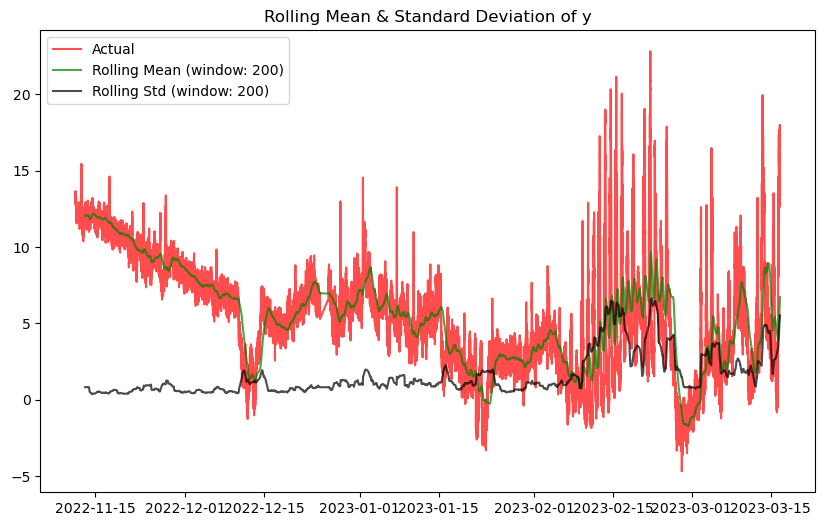

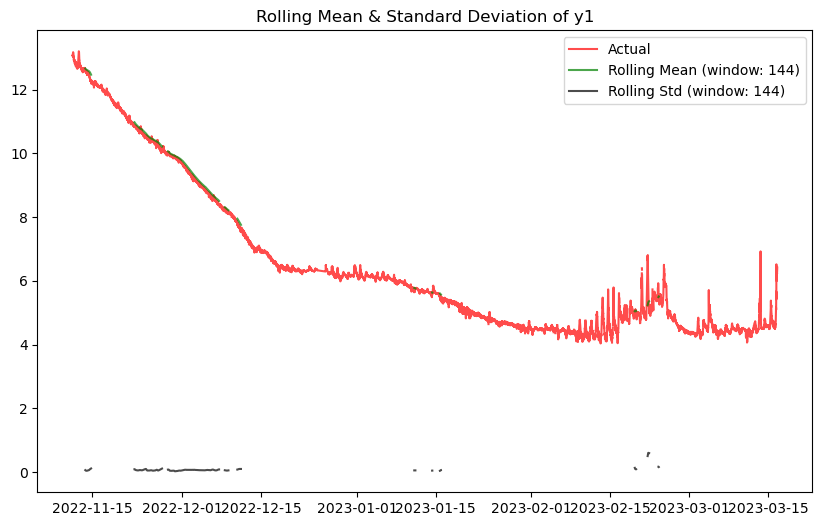

In [26]:
LakeAegeri.calc_rolling_statistics(window=200,column="y",show_plot="y1",save_plot="rolling_mean")
LakeAegeri.calc_rolling_statistics(window=144,column="y1",show_plot="y")

----------------------------------------
739 values are dropped/imputed in wind speed. 
----------------------------------------
---> Spline interpolation Imputation of wind-speed: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFrame with the column y1(statically) cleaned. The other parameters are not yet cleaned.
----------------------------------------
739 values are dropped/imputed in wind speed. 
----------------------------------------
The rows with physical impossible values are deleted. 
Visual check is advised with LakeAegeri raw.calc_rolling_statsitics(...,plot='Y')
->  A stationary Time Series is one which characteristics like mean and variance does not change over time.
Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:
--------------------
Dick

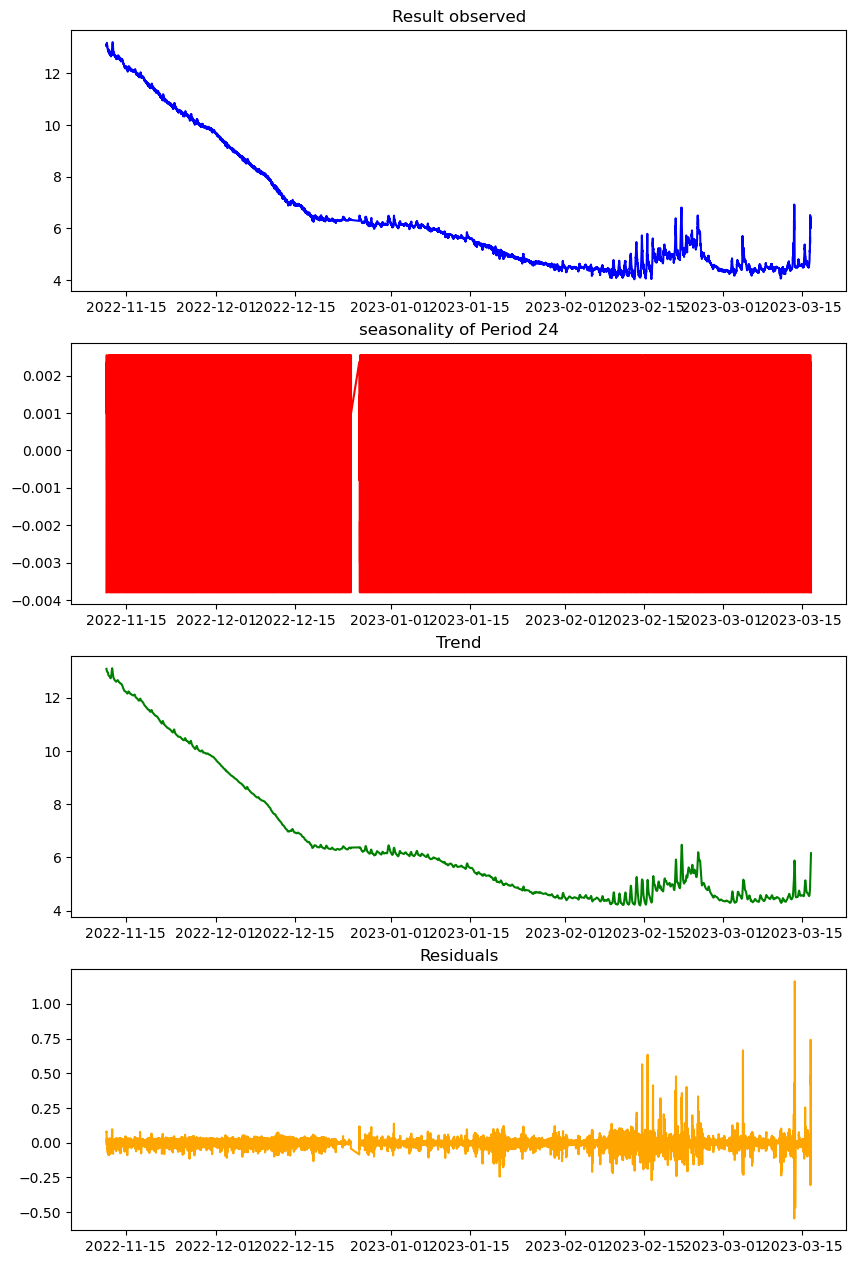

------- number of outliers of y1 (normalized residuals exceed 3 or -3): ---------
 False    16706
True       215
Name: is_outlier, dtype: int64


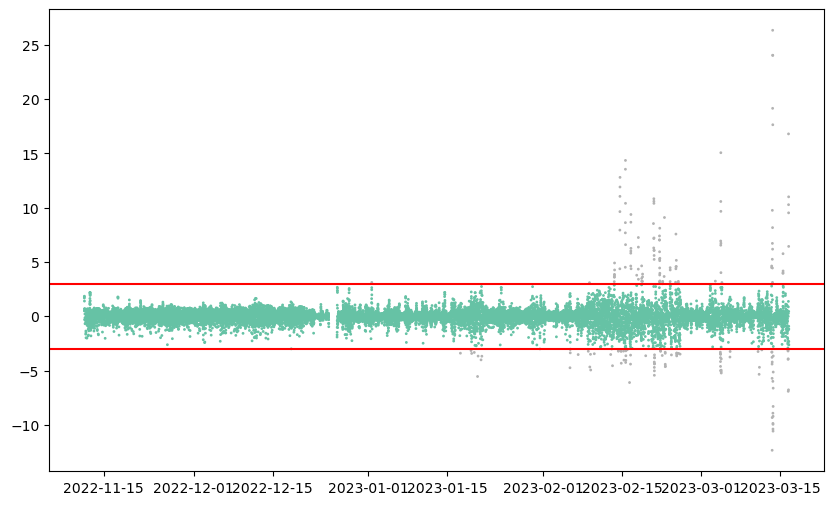

---> Splines Imputation of y1. It looks at outlier and puts a mathematical function over the dataset. Rhe method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.
The function returns a (TimeSeries) cleaned DataFrame with the selected column y1. The physical impossible outliers are not cleaned in this function.


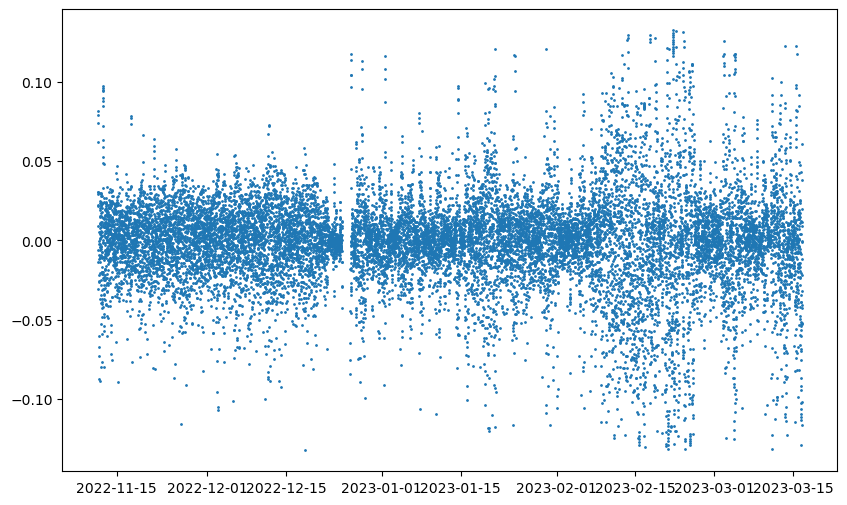

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


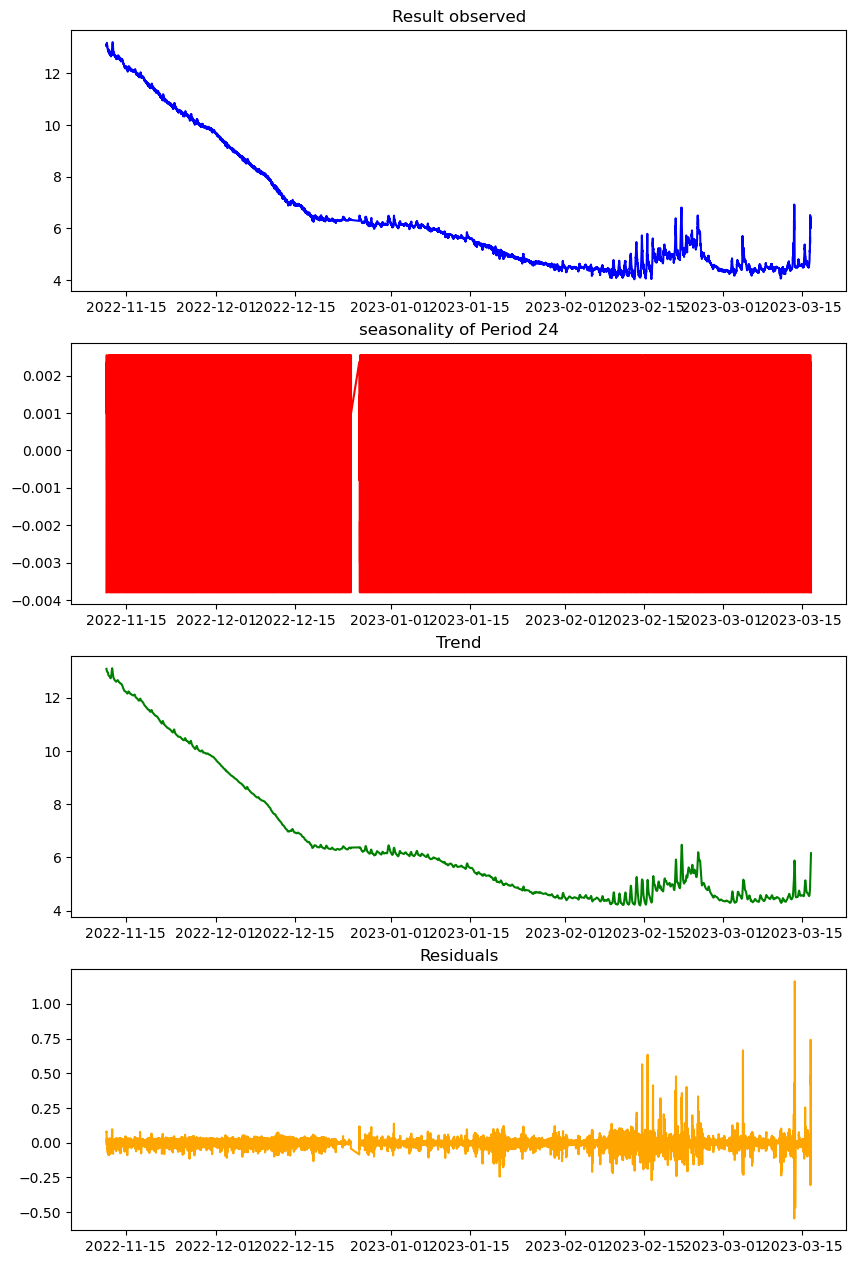

------- number of outliers of y1 (normalized residuals exceed 3 or -3): ---------
 False    16706
True       215
Name: is_outlier, dtype: int64


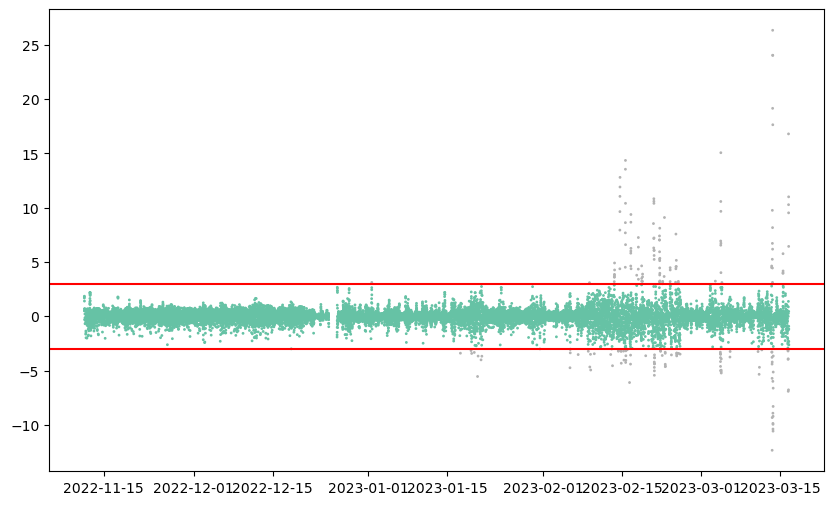

---> Simple imputation of y1: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3.
The function returns a (TimeSeries) cleaned DataFrame with the selected column y1. The other parameters are not yet cleaned and the physical impossible outlier are not cleaned in this function. 


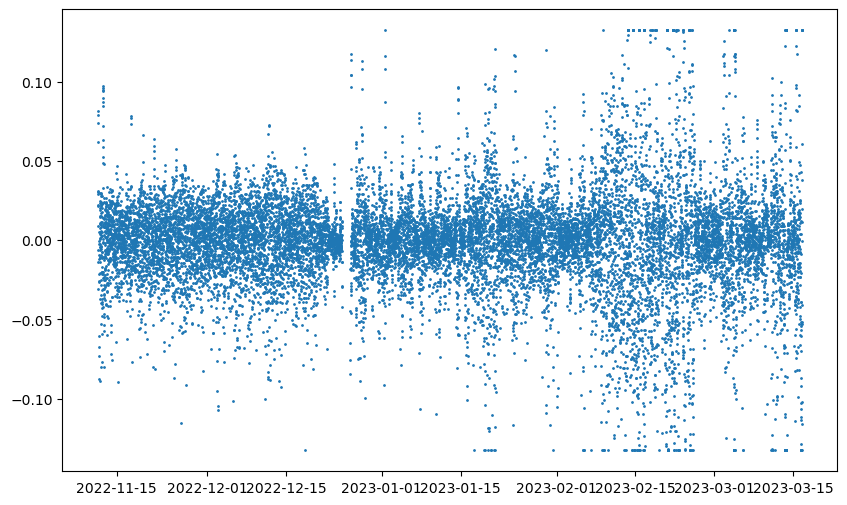

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
----------------------------------------
1057 values are dropped/imputed in skin temperature of LakeAegeri raw.
739 values are dropped/imputed in bulk temperature  of LakeAegeri raw.
17670 values are dropped/imputed in bulk temperature  of LakeAegeri raw
----------------------------------------
The rows with physical impossible values are deleted.
----------------------------------------
1057 values are dropped/imputed in skin temperature of LakeAegeri raw.
739 values are dropped/imputed in bulk temperature  of LakeAegeri raw.
17670 values are dropped/imputed in bulk temperature  of LakeAegeri raw
----------------------------------------
---> Spline interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFrame 

DataFrame LakeAegeri raw with columns: ['y', 'y1', 'datetime', 'air_temp', 'wind_speed', 'air_pressure', 'relative_humidity', 'solar_irradiance', 'meteo_timestamp']

In [27]:
LakeAegeri.remove_outliers_static("y1",imputation="y")
LakeAegeri.remove_outliers_static("y1",imputation="n")
LakeAegeri.check_stationarity("y1")
LakeAegeri.detect_outlier("y1",splines_imputation="y")
LakeAegeri.detect_outlier("y1",splines_imputation="n")
LakeAegeri.remove_outliers_temperature(skin_column_name="y",bulk_column_name="y1",airtemp_column_name="air_temp",imputation="n")
LakeAegeri.remove_outliers_temperature(skin_column_name="y",bulk_column_name="y1",airtemp_column_name="air_temp",imputation="y")
LakeAegeri.remove_outliers_static("y1",imputation="y")
LakeAegeri.remove_outliers_static("y1",imputation="n")

# Geneva BUC csv to big dataframe (FOR EXPORT THE DATAFRAME TO CSV FOR FURTHER INTERPRETATION)

In [43]:
import glob
import os

path="./data/Geneva/skin_temp/BUC_1m_csv"

all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df=df.set_index("x")
df_datetime = np.array([datetime.fromtimestamp(ts) for ts in df.index])
df['datetime'] = df_datetime
# x: time; y: Skin temp; y1: Rel hum; y2: Solar irrad; y3: wind speed; y4: wind dir; y5: rainfal; y6: air press
df=df[["datetime","y","y1","y2","y3","y4","y5","y6"]]

,datetime,y,y1,y2,y3,y4,y5,y6
x,,,,,,,,
1473332400,2016-09-08 13:00:00,20.47,NaN,NaN,NaN,NaN,NaN,NaN
1473336000,2016-09-08 14:00:00,21.12,NaN,NaN,NaN,NaN,NaN,NaN
1473339600,2016-09-08 15:00:00,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1473343200,2016-09-08 16:00:00,22.50,NaN,NaN,NaN,NaN,NaN,NaN
1473346800,2016-09-08 17:00:00,23.04,NaN,NaN,NaN,NaN,NaN,NaN


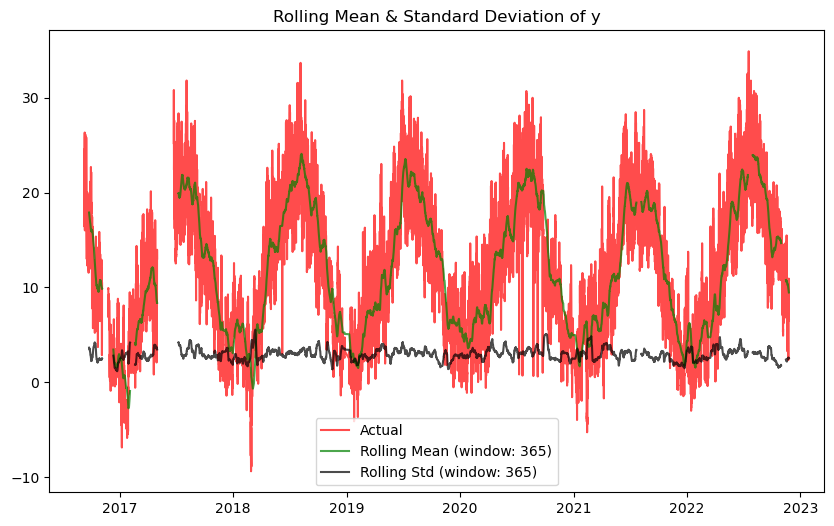

In [44]:
display(df.head())
BUC_geneva=Data(df,"BUC Geneva Raw",set_index_datetime_int="n")
BUC_geneva.calc_rolling_statistics("y",window=365,show_plot="y")

In [ ]:
#